In [1]:
import csv
import json
import random
import re
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns

import torch

from datasets import (
    Dataset,
    DatasetDict,
    concatenate_datasets,
    load_dataset,
    load_from_disk,
)
from transformers import (
    AutoModelForTokenClassification,
    AutoTokenizer,
    DataCollatorForTokenClassification,
    Trainer,
    TrainingArguments,
    set_seed,
)

import evaluate

from nameparser import HumanName
from names_dataset import NameDataset, NameWrapper
from ethnicseer import EthnicClassifier
import nltk
from nltk.corpus import wordnet as wn

import pycountry_convert as pc
import pycountry
import pickle

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, cohen_kappa_score

from transformers import BertTokenizerFast, BertForTokenClassification
from datasets import ClassLabel
from evaluate import load as load_metric
from sklearn.metrics import cohen_kappa_score
from itertools import combinations
import krippendorff

In [2]:
ontonotes_id_to_label = {
    0: "O", 1: "B-CARDINAL", 2: "B-DATE", 3: "I-DATE", 4: "B-PERSON", 5: "I-PERSON",
    6: "B-NORP", 7: "B-GPE", 8: "I-GPE", 9: "B-LAW", 10: "I-LAW", 11: "B-ORG", 12: "I-ORG",
    13: "B-PERCENT", 14: "I-PERCENT", 15: "B-ORDINAL", 16: "B-MONEY", 17: "I-MONEY",
    18: "B-WORK_OF_ART", 19: "I-WORK_OF_ART", 20: "B-FAC", 21: "B-TIME", 22: "I-CARDINAL",
    23: "B-LOC", 24: "B-QUANTITY", 25: "I-QUANTITY", 26: "I-NORP", 27: "I-LOC",
    28: "B-PRODUCT", 29: "I-TIME", 30: "B-EVENT", 31: "I-EVENT", 32: "I-FAC",
    33: "B-LANGUAGE", 34: "I-PRODUCT", 35: "I-ORDINAL", 36: "I-LANGUAGE"
}

conll_label_to_id = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3,
                     'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
id2label = {v: k for k, v in conll_label_to_id.items()}

ontonotes_to_conll_entity = {
    "PERSON": "PER", "ORG": "ORG", "GPE": "LOC", "LOC": "LOC",
    "NORP": "MISC", "FAC": "MISC", "EVENT": "MISC", "WORK_OF_ART": "MISC",
    "LAW": "MISC", "PRODUCT": "MISC", "LANGUAGE": "MISC",
    "DATE": None, "TIME": None, "PERCENT": None, "MONEY": None,
    "QUANTITY": None, "ORDINAL": None, "CARDINAL": None
}

In [21]:
def process_data(data_list):

    def process_single(data):
        word_ids = data['word_ids']
        predictions = data['predictions']
        gold = data['gold']
        tokenized_tokens = data['tokens']

        word_ids = [a for a in word_ids if a is not None]

        processed_predictions = []
        processed_gold = []

        current_word_id = None
        current_predictions = []
        current_gold = []

        for idx, word_id in enumerate(word_ids):
            if word_id != current_word_id:
                if current_predictions:
                    processed_predictions.append(
                        Counter(current_predictions).most_common(1)[0][0])
                    processed_gold.append(
                        Counter(current_gold).most_common(1)[0][0])

                current_word_id = word_id
                current_predictions = [predictions[idx]]
                current_gold = [gold[idx]]
            else:
                current_predictions.append(predictions[idx])
                current_gold.append(gold[idx])

        if current_predictions:
            processed_predictions.append(
                Counter(current_predictions).most_common(1)[0][0])
            processed_gold.append(
                Counter(current_gold).most_common(1)[0][0])

        return processed_predictions, processed_gold

    processed_predictions_list = []
    processed_gold_list = []

    i = 0
    for data in data_list:
        print(f"Progress: {i}/{len(data_list)}", end="\r")
        i += 1
        processed_predictions, processed_gold = process_single(data)
        processed_predictions_list.append(processed_predictions)
        processed_gold_list.append(processed_gold)

    return processed_predictions_list, processed_gold_list


def evaluate_predictions(p, test_data):
    predictions, labels, _ = p

    pred_indices = [np.argmax(p, axis=-1) for p in predictions]
    label_indices = labels

    pred_tags = [[id2label[p] for p, l in zip(p_seq, l_seq) if l != -100]
                 for p_seq, l_seq in zip(pred_indices, label_indices)]
    gold_tags = [[id2label[l] for l in l_seq if l != -100]
                 for l_seq in label_indices]

    def add_preds(example, idx):
        length = len(example['word_ids'])
        example['predictions'] = pred_tags[idx][:length]
        example['gold'] = gold_tags[idx][:length]
        return example

    test_data = test_data.map(add_preds, with_indices=True)

    print('test data mapped')

    pred, gold = process_data(test_data)

    print('data processed')
    flat_pred = [label for seq in pred for label in seq]
    flat_gold = [label for seq in gold for label in seq]

    print(classification_report(flat_gold, flat_pred, zero_division=0))

    return (flat_pred, flat_gold)

In [22]:
model_name = "bert-base-cased"

In [6]:
tokenizer = BertTokenizerFast.from_pretrained(model_name)

label_list = ['O', 'B-PER', 'I-PER', 'B-ORG',
              'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding=True,
        return_special_tokens_mask=True,
        return_offsets_mapping=True,
    )
    all_word_ids = []
    all_labels = []
    for i, labels in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        all_word_ids.append(word_ids)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            else:
                label_ids.append(labels[word_idx])
            previous_word_idx = word_idx
        all_labels.append(label_ids)

    tokenized_inputs["labels"] = all_labels
    tokenized_inputs["word_ids"] = all_word_ids
    return tokenized_inputs

In [7]:
result_paths = [
    "./results/bert-base-cased_conll_results.pkl",
    "./results/bert-base-uncased_conll_results.pkl",
    "./results/bert-base-cased_onto_results.pkl",
    "./results/bert-base-uncased_onto_results.pkl"
]

In [9]:
conll_main = load_from_disk("../splits/conll_main")
conll_clean = load_from_disk("../splits/conll_clean")

onto_main = load_from_disk("../splits/ontonotes_main")
ontonotes_clean = load_from_disk("../splits/ontonotes_clean")

In [17]:
conll_main = conll_main.map(tokenize_and_align_labels, batched=True)
onto_main = onto_main.map(tokenize_and_align_labels, batched=True)

Evaluating ./results/bert-base-cased_conll_results.pkl with model_name  bert-base-cased and test data as onto? True
test data mapped
data processed0/61371
              precision    recall  f1-score   support

       B-LOC       0.83      0.89      0.86     17495
      B-MISC       0.64      0.73      0.68     10657
       B-ORG       0.63      0.68      0.65     13041
       B-PER       0.90      0.93      0.91     15547
       I-LOC       0.71      0.66      0.68      5367
      I-MISC       0.66      0.37      0.47      7305
       I-ORG       0.90      0.71      0.79     18313
       I-PER       0.95      0.88      0.91     11086
           O       0.99      0.99      0.99   1011383

    accuracy                           0.97   1110194
   macro avg       0.80      0.76      0.77   1110194
weighted avg       0.97      0.97      0.97   1110194



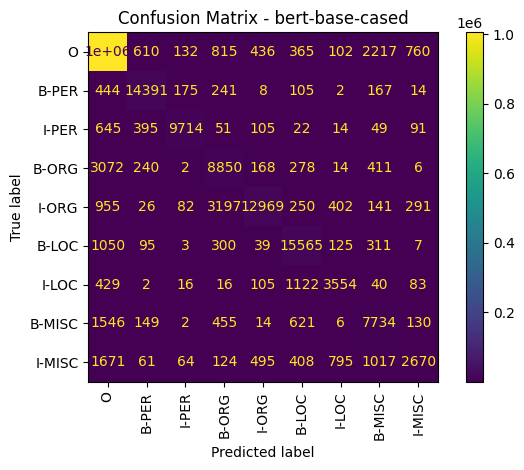

Map:   0%|          | 0/61371 [00:00<?, ? examples/s]

Evaluating ./results/bert-base-uncased_conll_results.pkl with model_name  bert-base-uncased and test data as onto? True


Map:   0%|          | 0/61371 [00:00<?, ? examples/s]

test data mapped
data processed0/61371
              precision    recall  f1-score   support

       B-LOC       0.82      0.89      0.85     17495
      B-MISC       0.64      0.69      0.66     10657
       B-ORG       0.61      0.63      0.62     13041
       B-PER       0.89      0.90      0.90     15547
       I-LOC       0.68      0.56      0.62      5367
      I-MISC       0.61      0.23      0.34      7305
       I-ORG       0.86      0.61      0.72     18313
       I-PER       0.93      0.87      0.90     11086
           O       0.98      0.99      0.99   1011383

    accuracy                           0.97   1110194
   macro avg       0.78      0.71      0.73   1110194
weighted avg       0.97      0.97      0.97   1110194



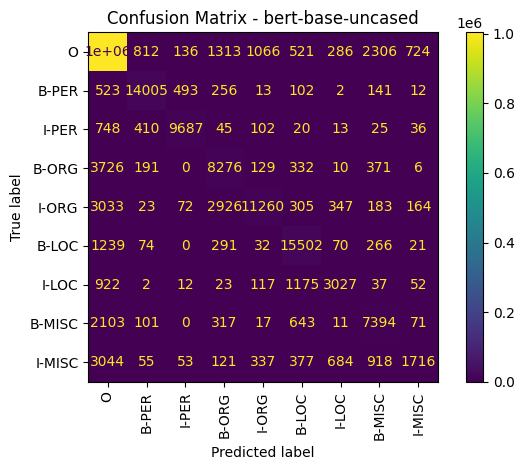

Evaluating ./results/bert-base-cased_onto_results.pkl with model_name  bert-base-cased and test data as onto? False
test data mapped
data processed4/16595
              precision    recall  f1-score   support

       B-LOC       0.80      0.80      0.80      8535
      B-MISC       0.76      0.68      0.71      4062
       B-ORG       0.75      0.50      0.60      7398
       B-PER       0.86      0.93      0.89      7975
       I-LOC       0.68      0.62      0.65      1356
      I-MISC       0.53      0.58      0.56      1380
       I-ORG       0.73      0.76      0.74      4251
       I-PER       0.89      0.99      0.94      5503
           O       0.98      0.99      0.99    201398

    accuracy                           0.95    241858
   macro avg       0.78      0.76      0.77    241858
weighted avg       0.95      0.95      0.95    241858



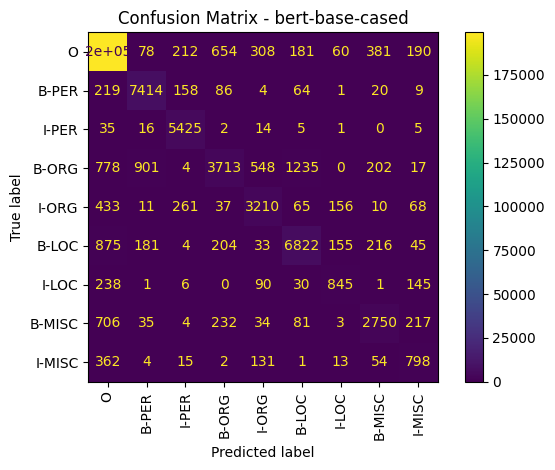

Evaluating ./results/bert-base-uncased_onto_results.pkl with model_name  bert-base-uncased and test data as onto? False


Map:   0%|          | 0/16595 [00:00<?, ? examples/s]

test data mapped
data processed4/16595
              precision    recall  f1-score   support

       B-LOC       0.79      0.90      0.84      8535
      B-MISC       0.77      0.69      0.73      4062
       B-ORG       0.73      0.52      0.61      7398
       B-PER       0.92      0.93      0.93      7975
       I-LOC       0.60      0.77      0.68      1356
      I-MISC       0.42      0.69      0.52      1380
       I-ORG       0.63      0.77      0.69      4251
       I-PER       0.90      0.98      0.94      5503
           O       0.99      0.98      0.99    201398

    accuracy                           0.95    241858
   macro avg       0.75      0.80      0.77    241858
weighted avg       0.95      0.95      0.95    241858



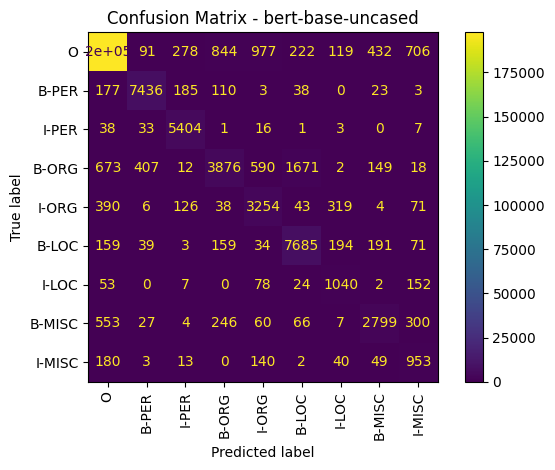

In [37]:
for i in range(len(result_paths)):
    path = result_paths[i]
    # Select model name
    model_name = "bert-base-uncased" if "uncased" in path else "bert-base-cased"
    tokenizer = BertTokenizerFast.from_pretrained(model_name)

    conll_main = load_from_disk("../splits/conll_main")
    onto_main = load_from_disk("../splits/ontonotes_main")
    conll_main = conll_main.map(tokenize_and_align_labels, batched=True)
    onto_main = onto_main.map(tokenize_and_align_labels, batched=True)
    # Select test data
    test_data = onto_main if "conll" in path else conll_main

    # Load predictions
    with open(path, "rb") as f:
        predictions = pickle.load(f)

    # Evaluate
    print(f"Evaluating {path} with model_name  {
          model_name} and test data as onto? {len(test_data) == len(onto_main)}")
    flat_preds, flat_labels = evaluate_predictions(predictions, test_data)

    label_order = list(conll_label_to_id.values())
    label_names = [id2label[i] for i in label_order]

    cm = confusion_matrix(flat_labels, flat_preds, labels=label_names)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=label_names)
    disp.plot(xticks_rotation=90)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.tight_layout()
    plt.show()

In [ ]:
for x, y in zip(flat_labels, flat_preds):
    if x != y:
        print(x)
        print(y)

In [46]:
index = 0  # flat index counter

for i, (tokens, gold_labels) in enumerate(zip(conll_main["tokens"], conll_main["labels"])):
    for j, (token, gold) in enumerate(zip(tokens, gold_labels)):
        pred = flat_preds[index]
        gold_label = flat_labels[index]
        if pred != gold_label and (('PER' in pred and 'ORG' in gold_label) or ('ORG' in pred and 'PER' in gold_label)):
            print(f"Sentence {i}, Token {j}: '{token}'")
            print(f"Gold: {gold_label}, Pred: {pred}")
            print("Full sentence:", " ".join(tokens))
            print()
        index += 1

Sentence 22, Token 1: 'Corser'
Gold: B-PER, Pred: B-ORG
Full sentence: 9. Corser 38:42.015

Sentence 128, Token 0: 'Spartak'
Gold: B-ORG, Pred: B-PER
Full sentence: Spartak 3 1 1 1 3 3 4

Sentence 187, Token 1: 'Barrick'
Gold: B-ORG, Pred: B-PER
Full sentence: The Barrick bid took observers by surprise , since Arequipa 's exploration was still in its early stages .

Sentence 365, Token 9: 'Kispest'
Gold: B-ORG, Pred: B-PER
Full sentence: In Skopje : Sloga Jugomagnat ( Macedonia ) 0 Kispest Honved

Sentence 365, Token 10: 'Honved'
Gold: I-ORG, Pred: I-PER
Full sentence: In Skopje : Sloga Jugomagnat ( Macedonia ) 0 Kispest Honved

Sentence 392, Token 3: 'Kent'
Gold: B-ORG, Pred: B-PER
Full sentence: At Cardiff : Kent 255-3 ( D. Fulton 64 , M. Walker 59 , C. Hooper

Sentence 424, Token 0: 'Russ'
Gold: B-ORG, Pred: B-PER
Full sentence: Russ Berrie president to retire in July .

Sentence 424, Token 1: 'Berrie'
Gold: I-ORG, Pred: I-PER
Full sentence: Russ Berrie president to retire in July .